
## Question 02

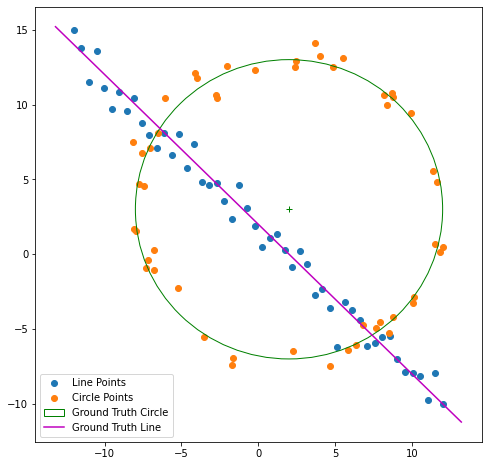

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
half_n = N // 2

r = 10  
x0_gt, y0_gt = 2, 3 
s = r / 16 

# Generate circle points
t = np.random.uniform(0, 2 * np.pi, half_n)  # Random angles
n = s * np.random.randn(half_n)  # Noise
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))


s = 1.0  
m, b = -1, 2  

x = np.linspace(-12, 12, half_n)  
y = m * x + b + s * np.random.randn(half_n)  
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line Points')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle Points')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')  # Plot circle center

# Plot ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground Truth Line')

# Display legend and plot
plt.legend()
plt.show()


### Line Equation and Consensus

In [2]:
import math
import numpy as np

# Defining dataset and number of points
num_points = X.shape[0]
data_points = X

def calculate_line_equation(point1_x, point1_y, point2_x, point2_y):
    """Calculate line equation coefficients from two points."""
    delta_x = point2_x - point1_x
    delta_y = point2_y - point1_y
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    coeff_a = delta_y / magnitude
    coeff_b = -delta_x / magnitude
    intercept = (coeff_a * point1_x) + (coeff_b * point1_y)
    return coeff_a, coeff_b, intercept

def total_least_squares_error(coefficients, selected_indices):
    """Calculate total least squares error for a line model."""
    coeff_a, coeff_b, intercept = coefficients
    return np.sum(np.square(coeff_a * data_points[selected_indices, 0] + 
                             coeff_b * data_points[selected_indices, 1] - intercept))

def constraint_function(coefficients):
    """Define constraint for coefficients."""
    return coefficients[0]**2 + coefficients[1]**2 - 1

constraints = ({'type': 'eq', 'fun': constraint_function})

def identify_inliers(data, coefficients, threshold):
    """Identify inliers based on the consensus function."""
    coeff_a, coeff_b, intercept = coefficients
    error = np.absolute(coeff_a * data[:, 0] + coeff_b * data[:, 1] - intercept)
    return error < threshold


### RANSAC Line Fitting

Optimal line model: [0.72225947 0.6916222  1.58642531]
(100, 2)


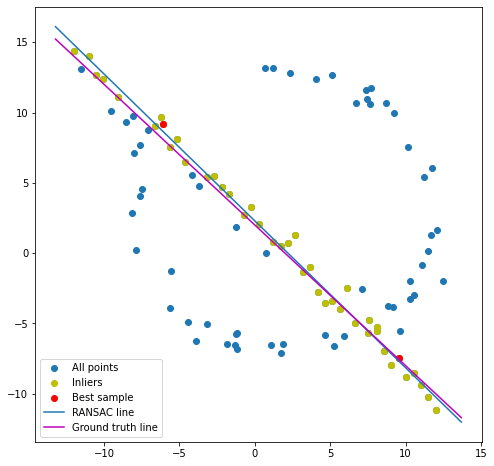

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


threshold = 1     
min_inliers_count = 0.4 * num_points  
min_points_required = 2  

line_inliers_indices = []  
max_iterations = 50
iteration_count = 0
optimal_line_model = []  
lowest_error = np.inf 
sample_indices_for_best_model = []  
model_result_from_best_sample = [] 
best_inliers_for_model = []  

while iteration_count < max_iterations:
    sample_indices = np.random.randint(0, num_points, min_points_required)  
    initial_guess = np.array([1, 1, 0])  
    optimization_result = minimize(fun=total_least_squares_error, args=(sample_indices,), 
                                   x0=initial_guess, tol=1e-6, constraints=constraints, 
                                   options={'disp': False})
    
    # Identify inliers for the current model
    line_inliers_indices = identify_inliers(data_points, optimization_result.x, threshold)
    
    # Check if the current model is sufficient (enough inliers)
    if line_inliers_indices.sum() > min_inliers_count:
        initial_guess = optimization_result.x
        optimization_result = minimize(fun=total_least_squares_error, 
                                       args=(line_inliers_indices,), 
                                       x0=initial_guess, tol=1e-6, 
                                       constraints=constraints, 
                                       options={'disp': False})
        
        if optimization_result.fun < lowest_error:
            optimal_line_model = optimization_result.x
            lowest_error = optimization_result.fun
            sample_indices_for_best_model = data_points[sample_indices, :]  # Update best sample
            model_result_from_best_sample = initial_guess
            best_inliers_for_model = line_inliers_indices  # Update best inliers
    
    iteration_count += 1

print('Optimal line model:', optimal_line_model)

# Visualization
print(data_points.shape)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(data_points[:, 0], data_points[:, 1], label='All points')

# Plot inliers
ax.scatter(data_points[best_inliers_for_model, 0], data_points[best_inliers_for_model, 1], 
           color='y', label='Inliers')

# Plot best sample points
ax.scatter(sample_indices_for_best_model[:, 0], sample_indices_for_best_model[:, 1], 
           color='r', label='Best sample')

# Plot the line model
x_min_val, x_max_val = ax.get_xlim()
x_values = np.array([x_min_val, x_max_val])
y_values = (-optimal_line_model[0] * x_values + optimal_line_model[2]) / optimal_line_model[1]  # Line equation
plt.plot(x_values, y_values, label='RANSAC line')

# Plot ground truth line (assuming m and b are defined)
y_values_truth = m * x_values + b
plt.plot(x_values, y_values_truth, color='m', label='Ground truth line')

plt.legend()
plt.show()


### Circle Fitting Using RANSAC

(58, 2)


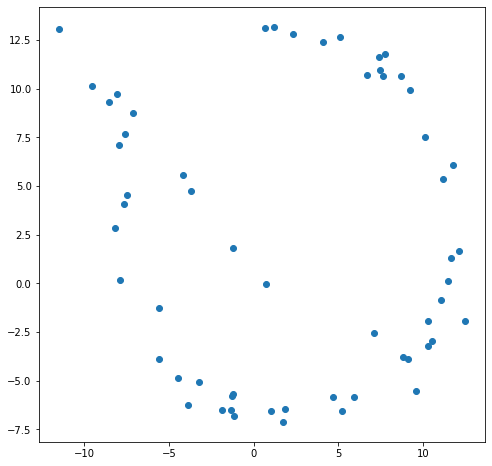

In [ ]:
from scipy import optimize
import random

# Extract outliers (points that are not inliers)
outlier_indices = np.where(np.logical_not(best_inliers_for_model))[0]
outlier_data_points = data_points[outlier_indices, :]
print(outlier_data_points.shape)

# Plotting outliers
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(outlier_data_points[:, 0], outlier_data_points[:, 1], label='Outlier Points')

num_outliers = outlier_data_points.shape[0]

def compute_circle_from_points(points):
    """ Calculate the center and radius of the circle from three points """
    point1, point2, point3 = points[0], points[1], points[2]
    temp = point2[0] ** 2 + point2[1] ** 2
    half_bc = (point1[0] ** 2 + point1[1] ** 2 - temp) / 2
    half_cd = (temp - point3[0] ** 2 - point3[1] ** 2) / 2
    determinant = (point1[0] - point2[0]) * (point2[1] - point3[1]) - (point2[0] - point3[0]) * (point1[1] - point2[1])

    # Center of the circle
    center_x = (half_bc * (point2[1] - point3[1]) - half_cd * (point1[1] - point2[1])) / determinant
    center_y = ((point1[0] - point2[0]) * half_cd - (point2[0] - point3[0]) * half_bc) / determinant

    radius = np.sqrt((center_x - point1[0]) ** 2 + (center_y - point1[1]) ** 2)
    return ((center_x, center_y), radius)

def identify_circle_inliers(points_list, center, radius):
    """ Identify inliers to a circle model based on a threshold """
    inliers = []
    threshold = radius / 3  # Set threshold to one-third of the radius

    for point in points_list:
        distance_error = np.sqrt((point[0] - center[0]) ** 2 + (point[1] - center[1]) ** 2) - radius
        if distance_error < threshold:
            inliers.append(point)

    return np.array(inliers)

def get_random_sample(points_list):
    """ Get a list of three random points from a given list """
    sample_indices = random.sample(range(len(points_list)), 3)
    return np.array([points_list[i] for i in sample_indices])

def calculate_distance_from_center(x_values, y_values, center_x, center_y):
    """ Calculate the distance of each 2D point from the circle's center """
    return np.sqrt((x_values - center_x) ** 2 + (y_values - center_y) ** 2)

def algebraic_distance(center, x_values, y_values):
    """ Calculate the algebraic distance between points and the mean circle centered at the given center """
    distances = calculate_distance_from_center(x_values, y_values, *center)
    return distances - distances.mean()

def fit_circle_via_least_squares(x_mean, y_mean, points):
    """ Fit a circle using least squares optimization """
    x_coordinates = points[:, 0]
    y_coordinates = points[:, 1]
    initial_center = x_mean, y_mean
    estimated_center, _ = optimize.leastsq(algebraic_distance, initial_center, (x_coordinates, y_coordinates))

    center_x, center_y = estimated_center
    mean_radius = calculate_distance_from_center(x_coordinates, y_coordinates, *estimated_center).mean()

    return (center_x, center_y), mean_radius


### RANSAC Circle Fitting Function

Optimal Circle Center: (13.915272111845045, 21.383245799173324)
Optimal Circle Radius: 24.891626011093138
(58, 2)
Inliers Found: [[  7.73807932  11.77531517]
 [ -5.58363211  -1.27626047]
 [ 10.56613904  -2.94934186]
 [ -1.19417654  -5.66539852]
 [  6.72969824  10.69063728]
 [  1.04053648  -6.56267257]
 [  5.24486288  -6.57928554]
 [ -1.86703856  -6.49235502]
 [ 11.65984645   1.30330613]
 [  5.11751532  12.63840467]
 [ 11.08506024  -0.85548203]
 [  7.46648224  10.97800412]
 [ 12.47336281  -1.95798457]
 [ 10.15638795   7.51357562]
 [ -1.2595733   -5.77650123]
 [ -7.8991455    0.19420932]
 [ 12.10962593   1.65677611]
 [  7.62905681  10.62947505]
 [ 11.48620391   0.13682386]
 [ 11.78434643   6.05606256]
 [  8.85444951  -3.78597928]
 [ -1.16889286  -6.81947529]
 [ -7.98321048   7.08887835]
 [  1.87645421  -6.45432468]
 [  4.07598144  12.37683185]
 [  9.62229345  -5.50754694]
 [  0.67181093  13.13147003]
 [ 10.30776293  -3.24557721]
 [  7.40715079  11.63319872]
 [  5.94381971  -5.86524743]
 

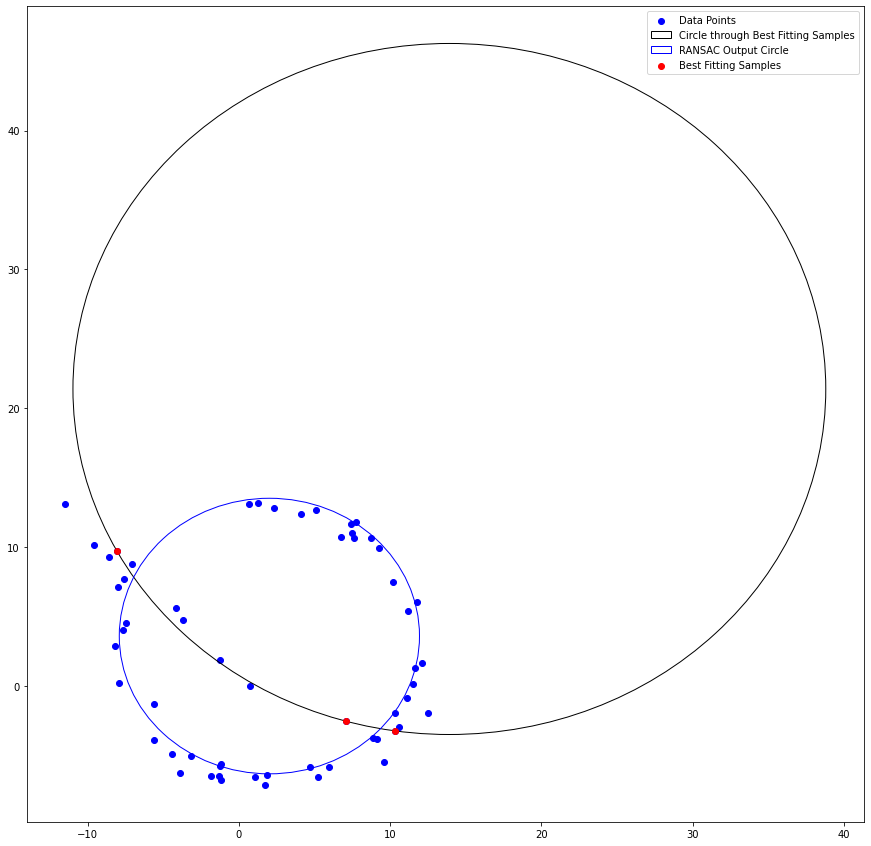

In [ ]:
def fit_circle_with_ransac(point_cloud, iterations):
    """ Fit a circle to a set of points using the RANSAC algorithm. 
        Returns the center, radius, best sample points, and their inliers.
    """
    optimal_sample = []
    optimal_circle_center = (0, 0)
    optimal_circle_radius = 0
    optimal_inliers = []
    max_inlier_count = 20
    
    for _ in range(iterations):
        sample_points = get_random_sample(point_cloud)  
        circle_center, circle_radius = compute_circle_from_points(sample_points)  
        inlier_points = identify_circle_inliers(point_cloud, circle_center, circle_radius)  
        inlier_count = len(inlier_points)

        # Update best approximation if current sample has more inliers
        if inlier_count > max_inlier_count:
            optimal_sample = sample_points
            max_inlier_count = inlier_count
            optimal_circle_center = circle_center
            optimal_circle_radius = circle_radius
            optimal_inliers = inlier_points

    print("Optimal Circle Center:", optimal_circle_center)
    print("Optimal Circle Radius:", optimal_circle_radius)

    return optimal_circle_center, optimal_circle_radius, optimal_sample, optimal_inliers

# Calculating the RANSAC outputs for the outlier dataset
optimal_center, optimal_radius, best_samples, inlier_points = fit_circle_with_ransac(outlier_data_points, 50000)
print(outlier_data_points.shape)
print("Inliers Found:", inlier_points)

# Plotting results
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plt.scatter(outlier_data_points[:, 0], outlier_data_points[:, 1], color='blue', label="Data Points")

# Plotting the circle created by the best fitting points
circle = plt.Circle(optimal_center, optimal_radius, fill=False, label="Circle through Best Fitting Samples", color='k')
ax.add_patch(circle)

# Plotting inliers
print("Ratio of Inliers =", len(inlier_points) / num_outliers * 100, "%")

# Estimate the circle using inliers with least squares method
ransac_circle_center, ransac_circle_radius = fit_circle_via_least_squares(optimal_center[0], optimal_center[1], inlier_points)
print("RANSAC Circle Center:", ransac_circle_center)
print("RANSAC Circle Radius:", ransac_circle_radius)
ransac_circle = plt.Circle(ransac_circle_center, ransac_circle_radius, fill=False, label="RANSAC Output Circle", color='b')
ax.add_patch(ransac_circle)

# Plotting the best fitting samples
ax.scatter(best_samples[:, 0], best_samples[:, 1], color='red', label="Best Fitting Samples")
ax.legend()


### Revised Plotting Code

Ratio of Inliers = 7.017543859649122 %
Inliers array has insufficient dimensions for plotting.
Center of RANSAC Circle = (2.0435741271449093, 3.870549248953072)
Radius of RANSAC Circle = 9.432686503699676


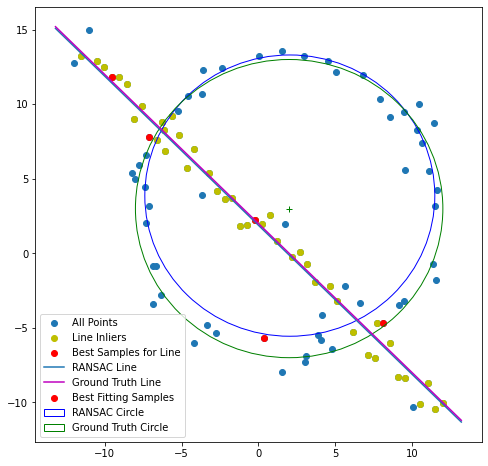

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot of all points
ax.scatter(dataset[:, 0], dataset[:, 1], label='All Points')

# Scatter plot for inliers of the line model
ax.scatter(dataset[best_inliers_line, 0], dataset[best_inliers_line, 1], color='y', label='Line Inliers')

# Scatter plot for the best sample points of the line model
ax.scatter(best_sample_line[:, 0], best_sample_line[:, 1], color='r', label='Best Samples for Line')

# Calculate and plot the RANSAC line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1] * x_ + best_model_line[2]) / best_model_line[1]
plt.plot(x_, y_, label='RANSAC Line')

# Plot the ground truth line
y_ground_truth = m * x_ + b
plt.plot(x_, y_ground_truth, color='m', label='Ground Truth Line')

# Check and plot the inliers for the circle model
print("Ratio of Inliers =", len(inliers) / len(outliers_data) * 100, "%")
if inliers.shape[1] >= 2:
    ax.scatter(inliers[:, 0], inliers[:, 1], color='c', label="Circle Inliers")
else:
    print("Inliers array has insufficient dimensions for plotting.")

# Scatter plot for the best fitting samples used to estimate the circle
ax.scatter(sample[:, 0], sample[:, 1], color='red', label="Best Fitting Samples")

# Plotting the RANSAC circle
print("Center of RANSAC Circle =", ransac_center)
print("Radius of RANSAC Circle =", ransac_radius)
ransac_circle = plt.Circle(ransac_center, ransac_radius, fill=False, label="RANSAC Circle", color='b')
ax.add_patch(ransac_circle)

# Plotting the ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Show legends and plot
ax.legend()
plt.show()


Circle Fitting on Linear Data:

If the data contains points that predominantly follow a linear pattern (like a line with some noise or outliers), fitting a circle first may lead to poor results. The circle will try to capture all points, even those that are aligned along the line, resulting in a large radius and poorly positioned center.
The circle model might treat line points as noise, incorrectly trying to encompass them into the circular fit.
Misidentification of Inliers:

When fitting a circle first, many points that should belong to the line may be misidentified as outliers, because they won’t fit the circular model. This will lead to a low ratio of inliers, weakening the overall RANSAC performance.
Order of Model Complexity:

A circle is a more complex geometric shape than a line, requiring three parameters (center coordinates and radius) compared to the two needed for a line (slope and intercept). If you fit the circle first, you risk overfitting or incorrectly modeling simpler structures like a line, which could reduce the effectiveness of RANSAC.